In [243]:
import pandas as pd
import geopandas as gpd
import polars as pl
import duckdb as db
import numpy as np
import wbgapi as wb
import scipy.stats as st

from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt

from scipy.stats import fisher_exact, chi2_contingency, ttest_rel, t

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import k_means 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix

# HW1


Overall rules:

- Do not split your answers into separate files. All answers must be in a single jupyter notebook. 
- Refrain from downloading and loading data from a local file unless specifically specified. Obtain all required remote data using the appropriate API.
- Refrain from cleaning data by hand on a spreadsheet. All cleaning must be done programmatically, with each step explained. This is so that I can replicate the procedure deterministically.
- Refrain from using code comments to explain what has been done. Document your steps by writing appropriate markdown cells in your notebook.
- Avoid duplicating code by copying and pasting it from one cell to another. If copying and pasting is necessary, develop a suitable function for the task at hand and call that function.
- When providing parameters to a function, never use global variables. Instead, always pass parameters explicitly and always make use of local variables.
- Document your use of LLM models (ChatGPT, Claude, Code Pilot etc). Either take screenshots of your steps and include them with this notebook, or give me a full log (both questions and answers) in a markdown file named HW2-LLM-LOG.md.

Failure to adhere to these guidelines will result in a 15-point deduction for each infraction.

## Q1

For this question, we are going to use [2019-2023 ISMEK Kesin Kayıtlı Kursiyer Verileri](https://data.ibb.gov.tr/dataset/2019-2020-yillari-arasindaki-ismek-egitim-alan-vatandas-verisi/resource/acc4c5d6-7654-48fb-a460-bffc6050f1b2?inner_span=True). 

[İSMEK](https://enstitu.ibb.istanbul/portal/enstitu_egitimler.aspx) provides education across a wide range of vocational and technical training, arts education, foreign languages, music instruction, information technology, and personal development. It has numerous training centers spread across the city, and it also offers advanced vocational education programs through specialized schools. The data anonymized data of indivuduals who participated in İSMEK training programs.

1. Get the data from its API. You may save a local copy for your own use but do not push into your git repo. The code you push must use the API data, not your local copy.
2. Calculate the percentages of individuals who completed the program across:
   - discipline ('alan')
   - education levels
   - age bracket
   - disability status
   - employment status
   - whether the program was online or face-to-face
4. Determine statistically if there are any differences in percentages of completion across the following categories. Explain which statistical tests you have used, and why.
   - discipline 
   - education levels
   - age bracket
   - disability status
   - employment status
   - whether the program was online or face-to-face
   Explain which statistical test you have used and why.
5. Now repeat the same analysis for each 'donem' and determine if the completion rates changed acrossed years for each of these categories above. Again, explain which statistical tests you have used, and why.

## Answers for Q1

Let us start by ingesting the data:

In [2]:
raw = pd.read_csv('https://data.ibb.gov.tr/dataset/badd88ba-e0af-4f7d-bb7d-18dc913a7a65/resource/acc4c5d6-7654-48fb-a460-bffc6050f1b2/download/2019-2023-ismek-kesin-kayitli-kursiyer-verileri.csv')
raw

,donem,egitim_durumu,engel_durumu,calisma_durumu,program,alan,hak_edilen_belge_tipi,kurs_merkezi,kurs_merkez_iilce,yas_araligi
0,2019-2020,İlkokul,Engel Yok,Çalışmıyor,Illustrator Çizim Uygulamaları 3,Grafik ve Teknik Tasarım,Belge Alamadı,UZAKTAN EĞİTİM,ESENLER,30-40 Yaş Arası
1,2019-2020,Lisans,Engel Yok,Çalışmıyor,C# Programlamaya Giriş,Bilişim Teknolojileri,Belge Alamadı,UZAKTAN EĞİTİM,ESENLER,20-30 Yaş Arası
2,2019-2020,Lisans,Engel Yok,Çalışmıyor,Excel Makrolara Giriş,Bilişim Teknolojileri,Katılım,UZAKTAN EĞİTİM,ESENLER,20-30 Yaş Arası
3,2019-2020,İlkokul,Engel Yok,Çalışmıyor,İğne Oyası,El Sanatları Teknolojisi,Sertifika-Teslim Edilmedi,EYÜPSULTAN ESENTEPE,EYÜPSULTAN,50-60 Yaş Arası
4,2019-2020,Ön Lisans,Engel Yok,Çalışıyor,Algoritma ve Programlamaya Temelleri,Bilişim Teknolojileri,Belge Alamadı,UZAKTAN EĞİTİM,ESENLER,30-40 Yaş Arası
...,...,...,...,...,...,...,...,...,...,...
337909,2022-2023,Lisans,Engel Yok,Çalışıyor,Dijital İletişim ve Etkileşim Uygulamaları,Bilişim Teknolojileri,Belge Alamadı,UZAKTAN EĞİTİM,ESENLER,30-40 Yaş Arası
337910,2022-2023,Lisans,Engel Yok,Çalışmıyor,İngilizce A1.2 Seviyesi,Dil Eğitimleri,Belge Alamadı,ŞİŞLİ MECİDİYEKÖY,ŞİŞLİ,40-50 Yaş Arası
337911,2022-2023,Lise,Engel Yok,Çalışmıyor,Etkili Problem Çözme Teknikleri,Kişisel Gelişim ve Eğitim,Belge Alamadı,UZAKTAN EĞİTİM,ESENLER,30-40 Yaş Arası
337912,2022-2023,Lise,Engel Yok,Öğrenci,MS Outlook 2019 Kullanımı,Bilişim Teknolojileri,Belge Alamadı,UZAKTAN EĞİTİM,ESENLER,20-30 Yaş Arası


We need to create a new column on whether the training done online or face-to-face:

In [7]:
raw['online'] = db.sql("""
  select (case kurs_merkezi when 'UZAKTAN EĞİTİM' then 1 else 0 end) as online 
  from raw
""").to_df()
raw

,donem,egitim_durumu,engel_durumu,calisma_durumu,program,alan,hak_edilen_belge_tipi,kurs_merkezi,kurs_merkez_iilce,yas_araligi,online
0,2019-2020,İlkokul,Engel Yok,Çalışmıyor,Illustrator Çizim Uygulamaları 3,Grafik ve Teknik Tasarım,Belge Alamadı,UZAKTAN EĞİTİM,ESENLER,30-40 Yaş Arası,1
1,2019-2020,Lisans,Engel Yok,Çalışmıyor,C# Programlamaya Giriş,Bilişim Teknolojileri,Belge Alamadı,UZAKTAN EĞİTİM,ESENLER,20-30 Yaş Arası,1
2,2019-2020,Lisans,Engel Yok,Çalışmıyor,Excel Makrolara Giriş,Bilişim Teknolojileri,Katılım,UZAKTAN EĞİTİM,ESENLER,20-30 Yaş Arası,1
3,2019-2020,İlkokul,Engel Yok,Çalışmıyor,İğne Oyası,El Sanatları Teknolojisi,Sertifika-Teslim Edilmedi,EYÜPSULTAN ESENTEPE,EYÜPSULTAN,50-60 Yaş Arası,0
4,2019-2020,Ön Lisans,Engel Yok,Çalışıyor,Algoritma ve Programlamaya Temelleri,Bilişim Teknolojileri,Belge Alamadı,UZAKTAN EĞİTİM,ESENLER,30-40 Yaş Arası,1
...,...,...,...,...,...,...,...,...,...,...,...
337909,2022-2023,Lisans,Engel Yok,Çalışıyor,Dijital İletişim ve Etkileşim Uygulamaları,Bilişim Teknolojileri,Belge Alamadı,UZAKTAN EĞİTİM,ESENLER,30-40 Yaş Arası,1
337910,2022-2023,Lisans,Engel Yok,Çalışmıyor,İngilizce A1.2 Seviyesi,Dil Eğitimleri,Belge Alamadı,ŞİŞLİ MECİDİYEKÖY,ŞİŞLİ,40-50 Yaş Arası,0
337911,2022-2023,Lise,Engel Yok,Çalışmıyor,Etkili Problem Çözme Teknikleri,Kişisel Gelişim ve Eğitim,Belge Alamadı,UZAKTAN EĞİTİM,ESENLER,30-40 Yaş Arası,1
337912,2022-2023,Lise,Engel Yok,Öğrenci,MS Outlook 2019 Kullanımı,Bilişim Teknolojileri,Belge Alamadı,UZAKTAN EĞİTİM,ESENLER,20-30 Yaş Arası,1


We need to create a new column for completion:

In [10]:
raw['basarisiz'] = db.sql("""
  select (case hak_edilen_belge_tipi when 'Belge Alamadı' then 1 else 0 end) as basarisiz
  from raw
""").to_df()
raw

,donem,egitim_durumu,engel_durumu,calisma_durumu,program,alan,hak_edilen_belge_tipi,kurs_merkezi,kurs_merkez_iilce,yas_araligi,online,basarisiz
0,2019-2020,İlkokul,Engel Yok,Çalışmıyor,Illustrator Çizim Uygulamaları 3,Grafik ve Teknik Tasarım,Belge Alamadı,UZAKTAN EĞİTİM,ESENLER,30-40 Yaş Arası,1,1
1,2019-2020,Lisans,Engel Yok,Çalışmıyor,C# Programlamaya Giriş,Bilişim Teknolojileri,Belge Alamadı,UZAKTAN EĞİTİM,ESENLER,20-30 Yaş Arası,1,1
2,2019-2020,Lisans,Engel Yok,Çalışmıyor,Excel Makrolara Giriş,Bilişim Teknolojileri,Katılım,UZAKTAN EĞİTİM,ESENLER,20-30 Yaş Arası,1,0
3,2019-2020,İlkokul,Engel Yok,Çalışmıyor,İğne Oyası,El Sanatları Teknolojisi,Sertifika-Teslim Edilmedi,EYÜPSULTAN ESENTEPE,EYÜPSULTAN,50-60 Yaş Arası,0,0
4,2019-2020,Ön Lisans,Engel Yok,Çalışıyor,Algoritma ve Programlamaya Temelleri,Bilişim Teknolojileri,Belge Alamadı,UZAKTAN EĞİTİM,ESENLER,30-40 Yaş Arası,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
337909,2022-2023,Lisans,Engel Yok,Çalışıyor,Dijital İletişim ve Etkileşim Uygulamaları,Bilişim Teknolojileri,Belge Alamadı,UZAKTAN EĞİTİM,ESENLER,30-40 Yaş Arası,1,1
337910,2022-2023,Lisans,Engel Yok,Çalışmıyor,İngilizce A1.2 Seviyesi,Dil Eğitimleri,Belge Alamadı,ŞİŞLİ MECİDİYEKÖY,ŞİŞLİ,40-50 Yaş Arası,0,1
337911,2022-2023,Lise,Engel Yok,Çalışmıyor,Etkili Problem Çözme Teknikleri,Kişisel Gelişim ve Eğitim,Belge Alamadı,UZAKTAN EĞİTİM,ESENLER,30-40 Yaş Arası,1,1
337912,2022-2023,Lise,Engel Yok,Öğrenci,MS Outlook 2019 Kullanımı,Bilişim Teknolojileri,Belge Alamadı,UZAKTAN EĞİTİM,ESENLER,20-30 Yaş Arası,1,1


Now, a function to calculate the completion percentages. 

In [36]:
def basari_orani(category):
    res = pd.crosstab(raw[category],raw['basarisiz'])
    return res/res.sum(axis=0)

I am going to collect all calculations in a single place.

In [37]:
workspace = {category: basari_orani(category) for category in ['alan','egitim_durumu','yas_araligi','engel_durumu','calisma_durumu','online']}

Now, let us investigate 'alan' category:

In [38]:
workspace['alan']

basarisiz,0,1
alan,,
Adobe Photoshop,0.000228,0.000000
Ahşap Tasarımı ve Teknolojileri,0.007537,0.002021
Aile ve Tüketici Bilimleri,0.000082,0.000018
Bahçe ve Koruların Bakımı,0.000182,0.000000
Bahçecilik,0.000282,0.000118
Bilişim Teknolojileri,0.167090,0.427555
Büro Yönetim ve Sekreterlik,0.000091,0.000263
CCNA-2),0.002913,0.000000
Dekoratif El Ürünleri Yapımı,0.007546,0.002306


We need to test if there are any significant differences between the '0' column and the '1' column.

In [39]:
ttest_rel(workspace['alan'][0],workspace['alan'][1])

TtestResult(statistic=np.float64(4.69770124401202e-16), pvalue=np.float64(0.9999999999999996), df=np.int64(56))

The result indicates that there is no statistically significant differences in completion rates. Let us repeat this for all categories:

In [40]:
{category: ttest_rel(workspace[category][0],workspace[category][1]) for category in ['alan','egitim_durumu','yas_araligi','engel_durumu','calisma_durumu','online']}

{'alan': TtestResult(statistic=np.float64(4.69770124401202e-16), pvalue=np.float64(0.9999999999999996), df=np.int64(56)),
 'egitim_durumu': TtestResult(statistic=np.float64(1.809195957355211e-16), pvalue=np.float64(0.9999999999999998), df=np.int64(9)),
 'yas_araligi': TtestResult(statistic=np.float64(-6.120348232259145e-17), pvalue=np.float64(1.0), df=np.int64(36)),
 'engel_durumu': TtestResult(statistic=np.float64(5.547367462995494e-16), pvalue=np.float64(0.9999999999999996), df=np.int64(5)),
 'calisma_durumu': TtestResult(statistic=np.float64(0.0), pvalue=np.float64(1.0), df=np.int64(4)),
 'online': TtestResult(statistic=np.float64(7.067234465720226e-17), pvalue=np.float64(1.0), df=np.int64(1))}

The results indicate that there are no statistically significant differences in completion rates across all categories.

Now, let us see if there are any differences across time:

In [55]:
res = basari_orani('donem')
res

basarisiz,0,1
donem,,
2019-2020,0.170130,0.110507
2020-2021,0.175592,0.271507
2021-2022,0.254303,0.219108
2022-2023,0.399975,0.398878


In [56]:
ttest_rel(res[0],res[1])

TtestResult(statistic=np.float64(2.031901447505313e-16), pvalue=np.float64(0.9999999999999998), df=np.int64(3))

As before, there is no statistically significant change in completion rates.

## Q2

For this question, use the temperature data ('temp.xlsx') I provided in the data folder. This is the monthly average surface temperatures provided by [Climate Change Knowledge Portal](https://climateknowledgeportal.worldbank.org/) per country since 1950.

1. Write a function that returns a k-means clustering model for countries using the temperature data for a given k.
2. Run the function for k=2. Determine which countries are in the cluster Turkey belongs to. Are there any reason why these countries are bundled together? Make an analysis.
3. Repeat the same analysis for k=3 and k=4. Are the clusters that Turkey appears in similar to the clusters for k=2? Make an analysis.

## Answers for Q2

Again, let us start by ingesting the data:

In [285]:
temp = pd.read_excel('../data/temp.xlsx')
temp

,code,name,1950-01,1950-02,1950-03,1950-04,1950-05,1950-06,1950-07,1950-08,...,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12
0,ABW,Aruba (Neth.),24.32,24.49,24.60,25.23,25.60,25.91,26.14,26.61,...,25.81,26.22,27.17,27.82,27.62,28.30,28.95,28.69,28.13,27.25
1,AFG,Afghanistan,-2.72,-4.07,3.42,8.26,17.25,22.29,24.82,22.67,...,10.03,14.20,18.99,24.94,25.67,23.89,19.79,14.70,9.17,4.06
2,AGO,Angola,21.09,21.42,20.94,20.92,19.81,19.48,19.21,19.78,...,22.69,22.82,22.80,20.81,20.37,22.24,24.38,25.11,23.88,23.34
3,AIA,Anguilla (U.K.),23.53,23.86,23.85,24.01,25.16,26.23,26.47,26.69,...,24.86,25.19,26.78,27.73,28.11,28.36,28.64,28.16,27.31,26.15
4,ALA,Finland,-3.87,-1.92,-0.63,3.43,7.33,12.16,15.44,17.57,...,-0.26,3.16,8.40,14.31,16.75,16.74,15.37,7.24,2.59,-0.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,WSM,Samoa,25.28,25.38,25.47,25.50,25.09,24.91,24.09,24.69,...,25.97,25.99,25.97,25.83,25.48,25.77,25.38,25.44,26.26,26.13
242,YEM,Republic of Yemen,17.06,17.85,22.69,23.89,26.99,27.92,27.56,26.20,...,24.42,26.73,29.10,31.34,32.13,31.57,30.73,26.63,24.46,20.52
243,ZAF,South Africa,22.29,21.92,20.84,16.69,12.75,11.73,10.52,12.54,...,21.14,18.11,14.39,11.92,11.19,14.13,16.37,19.51,22.83,22.58
244,ZMB,Zambia,20.56,21.03,21.00,20.62,17.96,17.47,18.15,18.74,...,22.51,21.96,21.38,20.08,18.45,21.07,25.40,27.24,25.70,24.37


The temperatures are recorded monthly, and are located on column onwards. I'll store the numerical data in X, and the labels in y. I'll construct a k-means model with k=2 and then predict labels for each country.

In [286]:
X = temp.iloc[:,2:]
y = temp['code']

def make_labels(k,X):
    model = k_means(X,n_clusters=k,max_iter=5000)
    combined = pd.DataFrame({'code': y, 'label': model[1]})
    return combined

make_labels(2,X)

,code,label
0,ABW,1
1,AFG,0
2,AGO,1
3,AIA,1
4,ALA,0
...,...,...
241,WSM,1
242,YEM,1
243,ZAF,1
244,ZMB,1


I am going to display the clusters on a world map:

In [288]:
world = gpd.read_file("../maps/ne_10m_admin_0_countries.shp")

def display_map(k):
    res = world.merge(make_labels(k,X), how="left", left_on="ISO_A3", right_on="code")
    res.plot(column='label',cmap='jet',figsize=(16,20))
    plt.show()

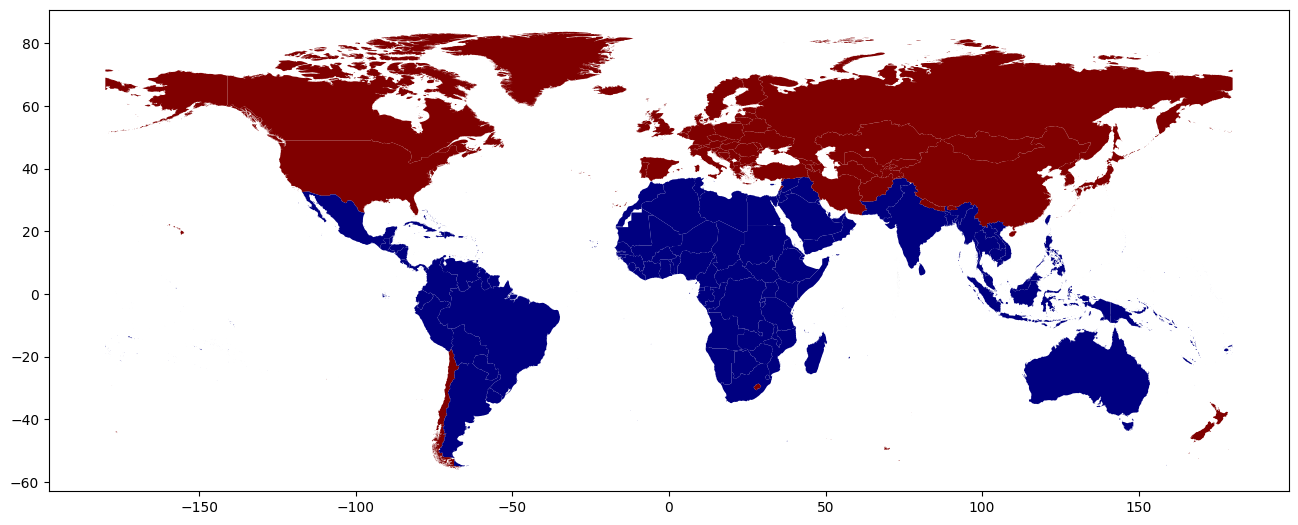

In [289]:
display_map(2)

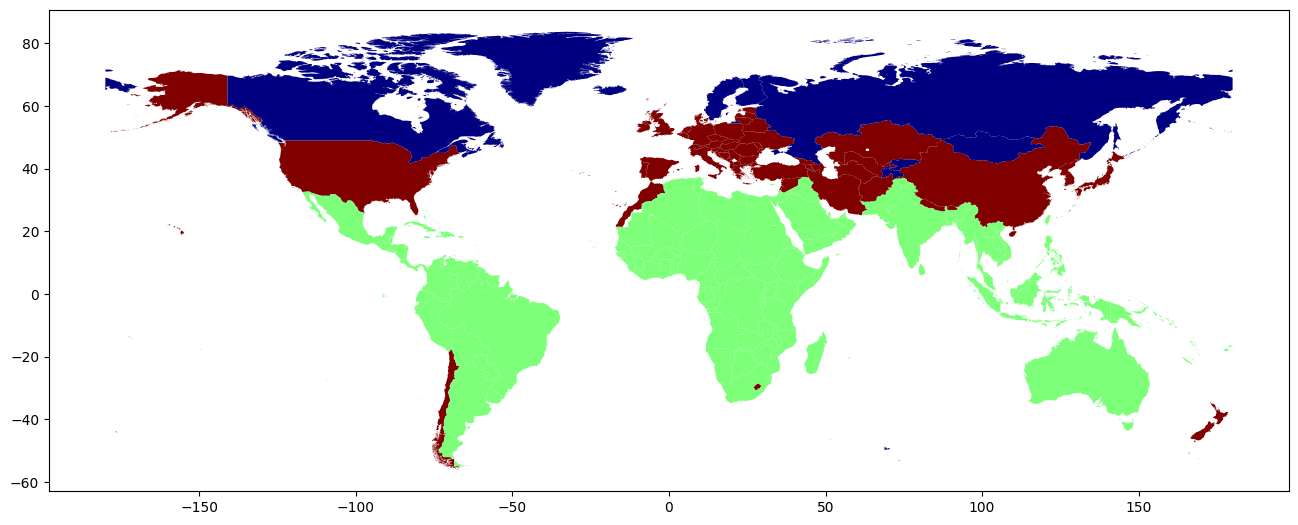

In [293]:
display_map(3)

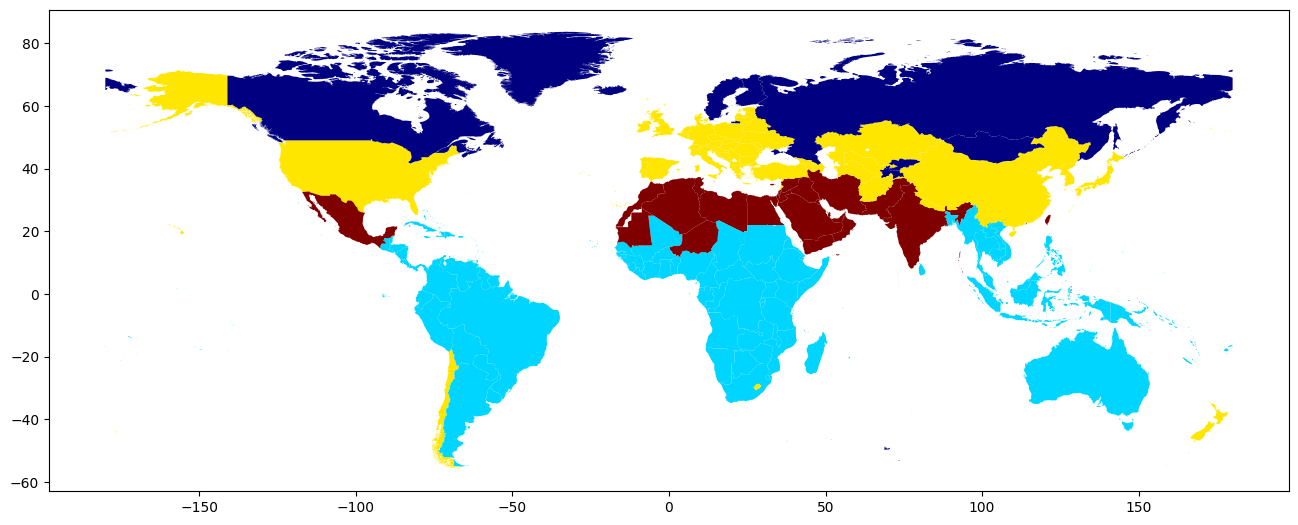

In [295]:
display_map(4)

The clustering appears to be done "longitudenally" and Turkey's cluster appears to be stable: mid range countries (with the exception of Chile, Argentina, and New Zealand). Among all clustering, k=4 appears to be the most reasonable. But run the code, and you'll see that clustering changes. Run until you obtain a clustering that makes sense.

## Q3

For this question, use the precipitation data ('precip.xlsx') I provided in the data folder. This is the monthly average precipitation provided by [Climate Change Knowledge Portal](https://climateknowledgeportal.worldbank.org/) per country since 1950.

1. Write a function that takes the country code as a parameter and returns a linear regression model for average precipitation against average surface temperature data we used in the earlier question.
2. Run the function for Turkey and plot the data and the regression model together.
3. Analyze if the model for Turkey fit. Which criteria did you use? Explain.
4. Now, run the function for each country and determine the country for which the regression model fit was the best. 

## Answers for Q3

Let us start by ingesting the data again.

In [140]:
precip = pd.read_excel('../data/precip.xlsx')
precip.index = precip['code']
precip

,code,name,1950-01,1950-02,1950-03,1950-04,1950-05,1950-06,1950-07,1950-08,...,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12
code,,,,,,,,,,,,,,,,,,,,,
ABW,ABW,Aruba (Neth.),72.31,64.31,37.02,37.27,122.28,136.19,93.34,98.50,...,10.24,5.53,4.31,9.99,18.30,31.97,3.27,118.42,138.24,46.77
AFG,AFG,Afghanistan,74.21,34.88,79.43,51.22,35.35,7.90,6.82,8.21,...,51.18,36.22,26.62,9.12,17.63,5.06,4.47,10.91,17.99,12.22
AGO,AGO,Angola,158.11,170.24,254.65,148.60,26.41,0.57,0.24,0.07,...,190.73,107.76,9.21,1.69,0.54,1.27,17.48,68.84,218.82,231.71
AIA,AIA,Anguilla (U.K.),64.29,19.83,27.63,30.75,26.95,65.10,42.24,180.56,...,20.14,58.27,51.20,104.21,81.00,113.15,48.72,319.55,53.29,48.03
ALA,ALA,Finland,48.59,45.68,24.31,53.03,33.94,29.54,30.67,49.87,...,80.92,23.28,19.01,15.63,67.61,111.90,35.61,112.05,91.02,50.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WSM,WSM,Samoa,141.69,167.47,83.75,134.44,111.38,92.14,152.92,84.09,...,269.53,156.73,231.49,129.97,149.51,86.57,82.10,193.68,204.27,313.04
YEM,YEM,Republic of Yemen,2.97,1.65,20.52,10.55,26.25,38.96,132.58,146.54,...,25.60,14.39,21.63,9.37,5.32,13.95,14.81,31.77,3.92,1.04
ZAF,ZAF,South Africa,81.04,104.90,108.40,84.61,41.73,25.44,8.79,8.12,...,39.91,16.29,48.75,21.93,14.34,5.03,31.22,47.36,26.44,100.18


I am going to need a regression model for precipitation vs temperature. For this purpose, I'll write a function that takes the country code and returns all relevant results.

In [159]:
def experiment(country):
    yagmur = np.array(precip.loc[country][2:]).reshape(-1,1)
    sicaklik = np.array(temp.loc[country][2:]).reshape(-1,1)
    model = LinearRegression()
    model.fit(sicaklik,yagmur)
    score = model.score(sicaklik,yagmur)
    pred = model.predict(sicaklik)
    return sicaklik, yagmur, pred, score

Let us run the code for Turkey, and plot the results.

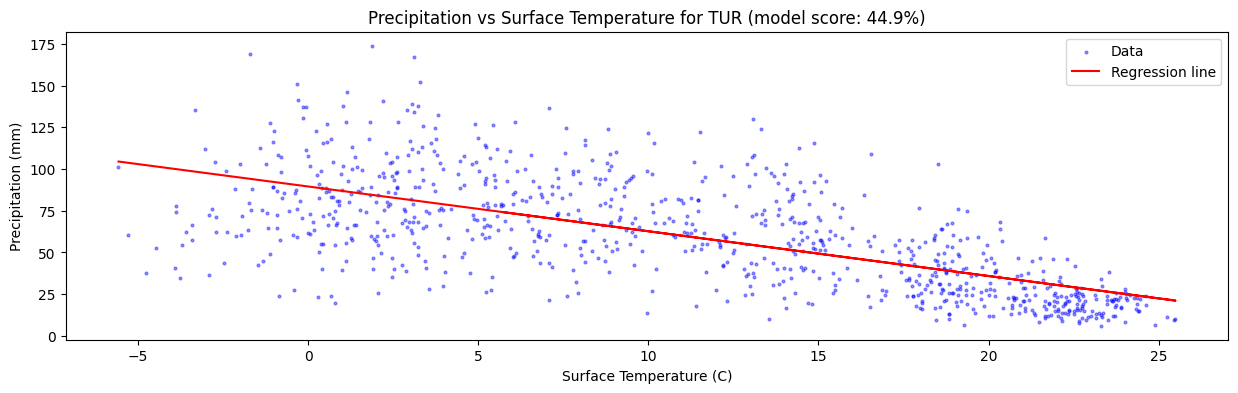

In [172]:
def plot_result(country):
    sicaklik,yagmur,y_pred,score = experiment(country)
    plt.figure(figsize=(15, 4))
    plt.xlabel('Surface Temperature (C)')
    plt.ylabel('Precipitation (mm)')
    plt.title(f'Precipitation vs Surface Temperature for {country} (model score: {np.round(score*100,1)}%)')
    plt.scatter(sicaklik, yagmur, label='Data', color='blue',alpha=0.4,s=4)
    plt.plot(sicaklik, y_pred, label='Regression line', color='red')
    plt.legend()
    plt.show()

plot_result('TUR')

Model's $R^2$-score is 45% which isn't good. So, we can safely say that there are other factors than the surface temperature that determines whether we get rain or not in Turkey.

Let us look at a tropical country, say Samoa. As you can see below, the fit is worse.

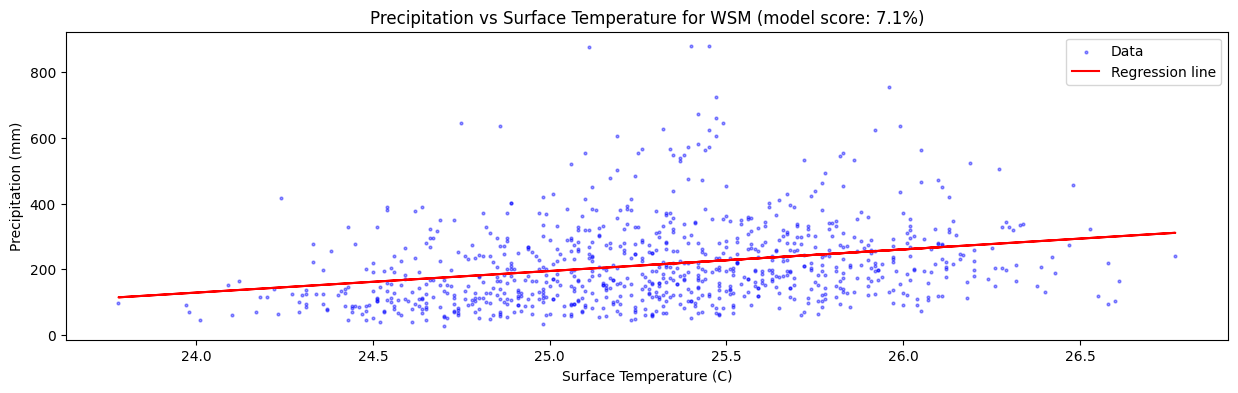

In [174]:
plot_result('WSM')

Now, let us run the experiment for every country in the list. I am going round the scores up so that we split the set of countries into two clusters: for those $R^2<50\%$ and for those $R^2>50\%$.

In [227]:
scores = []
for country in list(precip['code']):
    _,_,_,score = experiment(country)
    score = np.round(1+score,0)
    scores.extend([{'country': country, 'score': score}])

In [228]:
scores = pd.DataFrame(scores)
scores

,country,score
0,ABW,1.0
1,AFG,1.0
2,AGO,1.0
3,AIA,1.0
4,ALA,1.0
...,...,...
241,WSM,1.0
242,YEM,1.0
243,ZAF,1.0
244,ZMB,1.0


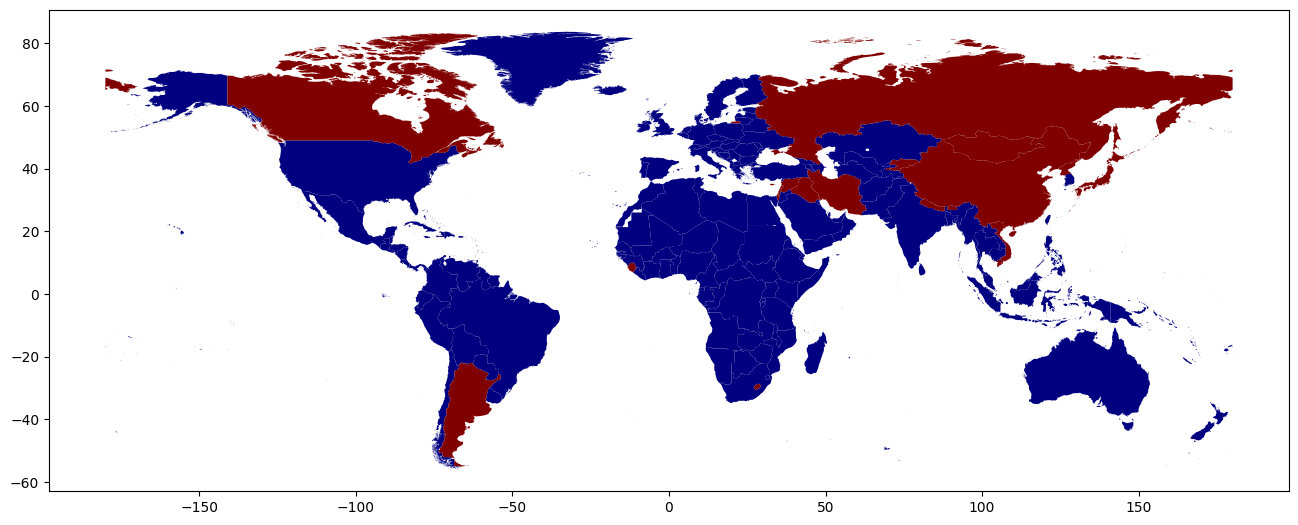

In [229]:
res = world.merge(scores, how="left", left_on="ISO_A3", right_on="country")
res.plot(column='score',cmap='jet',figsize=(16,20))
plt.show()

For some countries such as Canada and Russia it seems the model prediction works better.

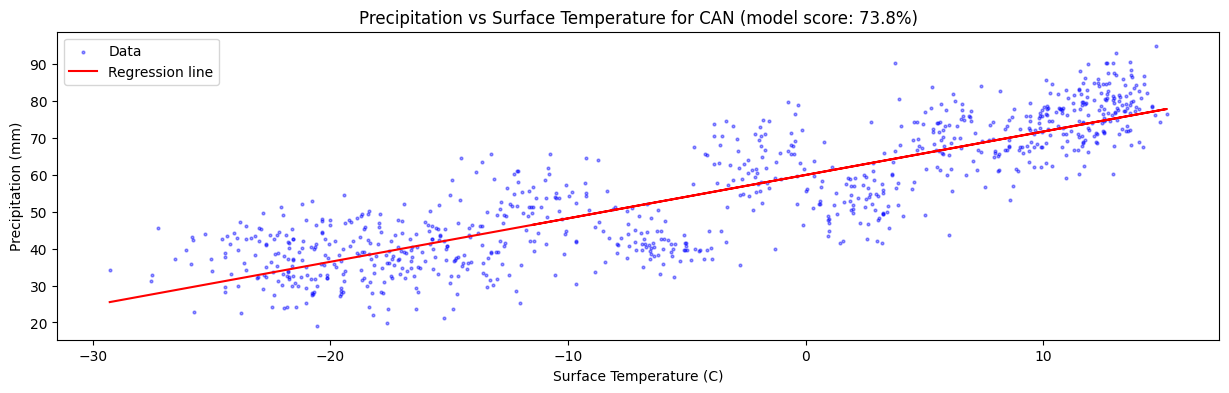

In [226]:
plot_result('CAN')

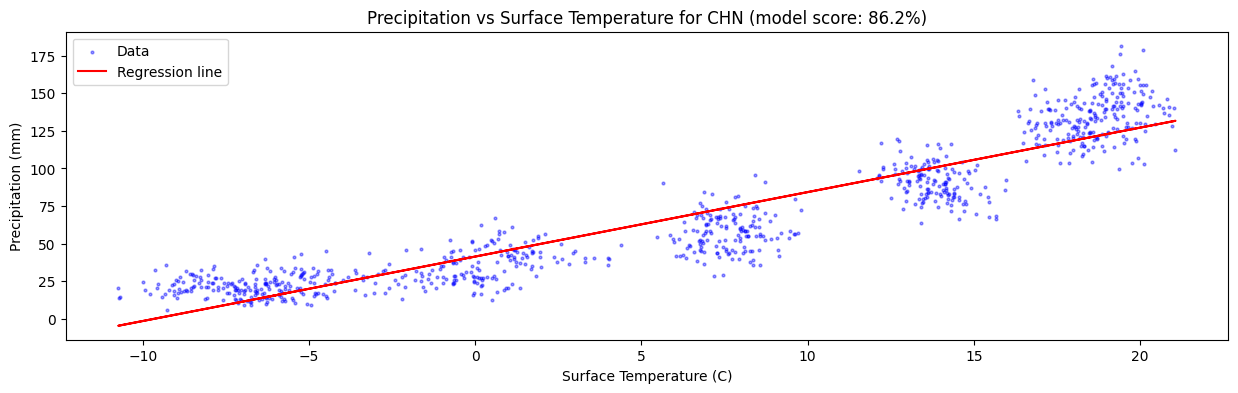

In [230]:
plot_result('CHN')

## Q4

For this question, we are going to use the [Musk Dataset (v2)](https://archive.ics.uci.edu/dataset/75/musk+version+2). This dataset describes a set of 102 molecules of which 39 are judged by human experts to be musks and the remaining 63 molecules are judged to be non-musks.  

1. Write a function that returns a k-nn model on the independent variables predicting the dependent variable for a given k.
2. Test the model for k=3 using a 10-fold cross-validation scheme. Determine the 95% confidence interval for the accuracy of the model.
3. Repeat the same analysis for k=1, k=5, k=7. Which of these models (including k=3) perform better? Explain.

In [231]:
connectionist_bench_sonar_mines_vs_rocks = fetch_ucirepo(id=151) 
  
X = connectionist_bench_sonar_mines_vs_rocks.data.features 
y = connectionist_bench_sonar_mines_vs_rocks.data.targets

In [273]:
def experiment(k,splits=10,conf_level=0.95):
    model = KNeighborsClassifier(n_neighbors=k)
    N = y.shape[0]
    scores = cross_val_score(model, np.array(X), np.array(y).reshape(N,), cv=splits)
    mean = np.mean(scores)
    std = np.std(scores)
    ci = t.interval(conf_level, splits-1, loc=mean, scale=std/np.sqrt(splits))
    return np.round(ci,2)

In [274]:
experiment(3)

array([0.49, 0.7 ])

In [275]:
pd.DataFrame([{'k': k, 'ci':experiment(k)} for k in [1,3,5,7]])

,k,ci
0,1,"[0.5, 0.71]"
1,3,"[0.49, 0.7]"
2,5,"[0.47, 0.72]"
3,7,"[0.46, 0.69]"


Since the confidence intervals overlap all models perform on par.